In [1]:
%matplotlib inline


# Demo for defining a custom regression objective and metric

Demo for defining customized metric and objective.  Notice that for simplicity reason
weight is not used in following example. In this script, we implement the Squared Log
Error (SLE) objective and RMSLE metric as customized functions, then compare it with
native implementation in XGBoost.

See :doc:`/tutorials/custom_metric_obj` for a step by step walkthrough, with other
details.

The `SLE` objective reduces impact of outliers in training dataset, hence here we also
compare its performance with standard squared error.


In [2]:
import numpy as np
import xgboost as xgb
from typing import Tuple, Dict, List
from time import time
import argparse
import matplotlib
from matplotlib import pyplot as plt

# shape of generated data.
kRows = 4096
kCols = 16

kOutlier = 10000                # mean of generated outliers
kNumberOfOutliers = 64

kRatio = 0.7
kSeed = 1994

kBoostRound = 20

np.random.seed(seed=kSeed)


def generate_data() -> Tuple[xgb.DMatrix, xgb.DMatrix]:
    '''Generate data containing outliers.'''
    x = np.random.randn(kRows, kCols)
    y = np.random.randn(kRows)
    y += np.abs(np.min(y))

    # Create outliers
    for i in range(0, kNumberOfOutliers):
        ind = np.random.randint(0, len(y)-1)
        y[ind] += np.random.randint(0, kOutlier)

    train_portion = int(kRows * kRatio)

    # rmsle requires all label be greater than -1.
    assert np.all(y > -1.0)

    train_x: np.ndarray = x[: train_portion]
    train_y: np.ndarray = y[: train_portion]
    dtrain = xgb.DMatrix(train_x, label=train_y)

    test_x = x[train_portion:]
    test_y = y[train_portion:]
    dtest = xgb.DMatrix(test_x, label=test_y)
    return dtrain, dtest


def native_rmse(dtrain: xgb.DMatrix,
                dtest: xgb.DMatrix) -> Dict[str, Dict[str, List[float]]]:
    '''Train using native implementation of Root Mean Squared Loss.'''
    print('Squared Error')
    squared_error = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'seed': kSeed
    }
    start = time()
    results: Dict[str, Dict[str, List[float]]] = {}
    xgb.train(squared_error,
              dtrain=dtrain,
              num_boost_round=kBoostRound,
              evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
              evals_result=results)
    print('Finished Squared Error in:', time() - start, '\n')
    return results


def native_rmsle(dtrain: xgb.DMatrix,
                 dtest: xgb.DMatrix) -> Dict[str, Dict[str, List[float]]]:
    '''Train using native implementation of Squared Log Error.'''
    print('Squared Log Error')
    results: Dict[str, Dict[str, List[float]]] = {}
    squared_log_error = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'tree_method': 'hist',
        'seed': kSeed
    }
    start = time()
    xgb.train(squared_log_error,
              dtrain=dtrain,
              num_boost_round=kBoostRound,
              evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
              evals_result=results)
    print('Finished Squared Log Error in:', time() - start)
    return results


def py_rmsle(dtrain: xgb.DMatrix, dtest: xgb.DMatrix) -> Dict:
    '''Train using Python implementation of Squared Log Error.'''
    def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
        '''Compute the gradient squared log error.'''
        y = dtrain.get_label()
        return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

    def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
        '''Compute the hessian for squared log error.'''
        y = dtrain.get_label()
        return ((-np.log1p(predt) + np.log1p(y) + 1) /
                np.power(predt + 1, 2))

    def squared_log(predt: np.ndarray,
                    dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
        '''Squared Log Error objective. A simplified version for RMSLE used as
        objective function.

        :math:`\frac{1}{2}[log(pred + 1) - log(label + 1)]^2`

        '''
        predt[predt < -1] = -1 + 1e-6
        grad = gradient(predt, dtrain)
        hess = hessian(predt, dtrain)
        return grad, hess

    def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
        ''' Root mean squared log error metric.

        :math:`\sqrt{\frac{1}{N}[log(pred + 1) - log(label + 1)]^2}`
        '''
        y = dtrain.get_label()
        predt[predt < -1] = -1 + 1e-6
        elements = np.power(np.log1p(y) - np.log1p(predt), 2)
        return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

    results: Dict[str, Dict[str, List[float]]] = {}
    xgb.train({'tree_method': 'hist', 'seed': kSeed,
               'disable_default_eval_metric': 1},
              dtrain=dtrain,
              num_boost_round=kBoostRound,
              obj=squared_log,
              custom_metric=rmsle,
              evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
              evals_result=results)

    return results


def plot_history(rmse_evals, rmsle_evals, py_rmsle_evals):
    fig, axs = plt.subplots(3, 1)
    ax0: matplotlib.axes.Axes = axs[0]
    ax1: matplotlib.axes.Axes = axs[1]
    ax2: matplotlib.axes.Axes = axs[2]

    x = np.arange(0, kBoostRound, 1)

    ax0.plot(x, rmse_evals['dtrain']['rmse'], label='train-RMSE')
    ax0.plot(x, rmse_evals['dtest']['rmse'], label='test-RMSE')
    ax0.legend()

    ax1.plot(x, rmsle_evals['dtrain']['rmsle'], label='train-native-RMSLE')
    ax1.plot(x, rmsle_evals['dtest']['rmsle'], label='test-native-RMSLE')
    ax1.legend()

    ax2.plot(x, py_rmsle_evals['dtrain']['PyRMSLE'], label='train-PyRMSLE')
    ax2.plot(x, py_rmsle_evals['dtest']['PyRMSLE'], label='test-PyRMSLE')
    ax2.legend()


def main(args):
    dtrain, dtest = generate_data()
    rmse_evals = native_rmse(dtrain, dtest)
    rmsle_evals = native_rmsle(dtrain, dtest)
    py_rmsle_evals = py_rmsle(dtrain, dtest)

    # if args.plot != 0:
    plot_history(rmse_evals, rmsle_evals, py_rmsle_evals)
    plt.show()


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(
#         description='Arguments for custom RMSLE objective function demo.')
#     parser.add_argument(
#         '--plot',
#         type=int,
#         default=1,
#         help='Set to 0 to disable plotting the evaluation history.')
#     args = parser.parse_args()
#     main(args)

Squared Error
[0]	dtrain-rmse:686.29804	dtest-rmse:748.03114
[1]	dtrain-rmse:630.14087	dtest-rmse:752.57788
[2]	dtrain-rmse:598.52486	dtest-rmse:766.40288
[3]	dtrain-rmse:557.35110	dtest-rmse:776.62268
[4]	dtrain-rmse:520.73505	dtest-rmse:789.23284
[5]	dtrain-rmse:502.21779	dtest-rmse:804.59523
[6]	dtrain-rmse:455.84582	dtest-rmse:810.78900
[7]	dtrain-rmse:418.19617	dtest-rmse:812.74063
[8]	dtrain-rmse:381.35518	dtest-rmse:823.45388
[9]	dtrain-rmse:368.81501	dtest-rmse:830.93528
[10]	dtrain-rmse:348.78104	dtest-rmse:835.42229
[11]	dtrain-rmse:339.31365	dtest-rmse:843.97564
[12]	dtrain-rmse:323.06642	dtest-rmse:846.53312
[13]	dtrain-rmse:312.49508	dtest-rmse:849.42713
[14]	dtrain-rmse:298.48951	dtest-rmse:851.21743
[15]	dtrain-rmse:292.86298	dtest-rmse:856.53685
[16]	dtrain-rmse:285.69906	dtest-rmse:859.72634
[17]	dtrain-rmse:281.79026	dtest-rmse:861.52592
[18]	dtrain-rmse:270.30166	dtest-rmse:861.75484
[19]	dtrain-rmse:256.31211	dtest-rmse:862.45007
Finished Squared Error in: 0.0609951

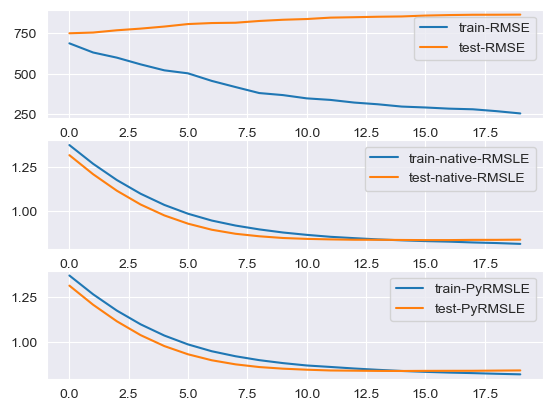

In [3]:
# parser = argparse.ArgumentParser(
#         description='Arguments for custom RMSLE objective function demo.')
# parser.add_argument(
#     '--plot',
#     type=int,
#     default=1,
#     help='Set to 0 to disable plotting the evaluation history.')
# args = parser.parse_args()
# print(parser)
main(1)